# SC4002 / CE4045 / CZ4045 NLP — Assignment — Part 3.2: CNN

This notebook replaces the simple RNN from Part 2 with a **Convolutional Neural Network (CNN)** as required in Part 3.2, and logs:
- Training loss per epoch
- Validation and training accuracy per epoch 
- Final test accuracy

## Setup

In [1]:
from torchtext import data, datasets
import torch
import spacy
import random
import numpy as np

def set_seed(seed = 0):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed()

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils import clip_grad_norm_
import torch.nn as nn
from itertools import product
import pandas as pd
from collections import Counter, defaultdict

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading Prepared TREC Dataset

We reuse the same data pipeline introducted in 3.1 to load the TREC dataset that was prepared in Part 1.  

In [2]:
LOAD_PREPARED = True  
if LOAD_PREPARED:
    bundle = torch.load("trec_artifacts.pt", map_location="cpu")


    TEXT = data.Field(**bundle["text_field_kwargs"])
    LABEL = data.LabelField(**bundle["label_field_kwargs"])

    fields = [("text", TEXT), ("label", LABEL)]

    def rebuild(dataset_blob):
        examples = [
            data.Example.fromlist([item["tokens"], item["label"]], fields)
            for item in dataset_blob
        ]
        return data.Dataset(examples, fields)

    train_data = rebuild(bundle["train_examples"])
    valid_data = rebuild(bundle["valid_examples"])
    test_data  = rebuild(bundle["test_examples"])

    for ds in (train_data, valid_data, test_data):
        ds.sort_key = lambda ex: len(ex.text)

    TEXT.build_vocab([])
    TEXT.vocab.itos = bundle["text_vocab_itos"]
    unk_token = TEXT.unk_token
    if unk_token not in TEXT.vocab.itos:
        raise ValueError("UNK token missing from serialized vocabulary.")
    unk_index = TEXT.vocab.itos.index(unk_token)
    TEXT.vocab.stoi = defaultdict(lambda: unk_index,
                                  {tok: i for i, tok in enumerate(TEXT.vocab.itos)})
    TEXT.vocab.vectors = bundle["text_vocab_vectors"]

    LABEL.build_vocab([])
    LABEL.vocab.itos = bundle["label_vocab_itos"]
    LABEL.vocab.stoi = {tok: i for i, tok in enumerate(LABEL.vocab.itos)}



    pretrained_embeddings = TEXT.vocab.vectors

    train_iter, valid_iter, test_iter = data.BucketIterator.splits(
        (train_data, valid_data, test_data),
        batch_size=bundle["batch_size"],
        sort_within_batch=True,
        device=DEVICE,
    )
    print("Artifacts loaded.")

Artifacts loaded.


In [3]:
# Build from scratch via torchtext 0.4.0 ---

USE_TORCHTEXT_PIPELINE = False  

if USE_TORCHTEXT_PIPELINE:
    from torchtext import data, datasets
    # tokenizer setup
    TEXT = data.Field(tokenize='spacy', tokenizer_language='en_core_web_sm', include_lengths=True)
    LABEL = data.LabelField()
    train_data, test_data = datasets.TREC.splits(TEXT, LABEL, fine_grained=False)

    # split train/valid (80/20)
    train_data, valid_data = train_data.split(split_ratio=0.8, random_state=random.seed(42))

    # Build vocab using your chosen pretrained vectors (Word2Vec or GloVe). Example with GloVe 100d:
    # WARNING: This may attempt a download if not present locally.
    vectors_name, vectors_dim = 'glove.6B.100d', 100
    TEXT.build_vocab(train_data, vectors=vectors_name, max_size=25000)
    LABEL.build_vocab(train_data)

    # Create iterators
    BATCH_SIZE = 64
    device = DEVICE
    train_iter, valid_iter, test_iter = data.BucketIterator.splits(
        (train_data, valid_data, test_data),
        batch_size=BATCH_SIZE,
        sort_within_batch=True,
        device=device
    )

    # Extract pretrained embeddings from vocab
    pretrained_embeddings = TEXT.vocab.vectors  # FloatTensor [vocab_size, emb_dim]
else:
    print("Skipping torchtext pipeline. Make sure you load your artifacts in Option A instead.")

Skipping torchtext pipeline. Make sure you load your artifacts in Option A instead.


## Relevant Functions from Part 2

In [4]:
# Define Dataset Class for Qn 2 - Make them learnable parameters
class SentenceDataset(Dataset):
    def __init__(self, text, label, vocab):
        self.text = text
        self.label = label
        self.vocab = vocab

    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, idx):
        tokens = self.text[idx].split()
        label = self.label[idx]
        indices = [self.vocab[token] if token in self.vocab else self.vocab['<unk>'] for token in tokens]

        return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)

def collate_fn(batch):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=TEXT.vocab.stoi['<pad>'])
    labels = torch.stack(labels)
    return texts_padded, labels

In [5]:
# Create train, valid, test texts and labels 
train_texts = [" ".join(example.text) for example in train_data.examples]
train_labels = [LABEL.vocab.stoi[example.label] for example in train_data.examples]

valid_texts = [" ".join(example.text) for example in valid_data.examples]
valid_labels = [LABEL.vocab.stoi[example.label] for example in valid_data.examples]

test_texts = [" ".join(example.text) for example in test_data.examples]
test_labels = [LABEL.vocab.stoi[example.label] for example in test_data.examples]

# Create Dataset instances
train_dataset = SentenceDataset(train_texts, train_labels, TEXT.vocab.stoi)
valid_dataset = SentenceDataset(valid_texts, valid_labels, TEXT.vocab.stoi)
test_dataset = SentenceDataset(test_texts, test_labels, TEXT.vocab.stoi)

# Check length of train dataset and train data
print(len(train_dataset))
print(len(train_data))

4362
4362


In [6]:
# Define the RNN Classifier, here we do only a single hidden layer to keep it small and simple
# We take input word embeddings, pass through RNN, apply dropout, and then a fully connected layer to get logits for 6 classes (as per qn requirement)
class ClassifierRNN(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, dropout=0.0):
        super(ClassifierRNN, self).__init__()
        num_embeddings, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float), freeze=False)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 6) # since 6 possible labels

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        hidden = self.dropout(hidden[-1]) # Default is to take last layer's hidden state
        out = self.fc(hidden)
        return out

In [7]:
# Define training, evaluation, and testing loops
def train_loop(model, loader, optimizer, criterion, grad_clip=False, max_norm=1.0):
    model.train()
    total_loss, total_correct = 0, 0
    for texts, labels in loader:
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()

        if grad_clip:
            clip_grad_norm_(model.parameters(), max_norm=max_norm)

        optimizer.step()
        total_loss += loss.item()
        total_correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(loader)
    avg_correct = total_correct / len(loader.dataset)
    return avg_loss, avg_correct

def eval_loop(model, loader, criterion):
    model.eval()
    total_loss, total_correct = 0, 0

    with torch.no_grad():
        for texts, labels in loader:
            outputs = model(texts)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            total_correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(loader)
    avg_correct = total_correct / len(loader.dataset)
    return avg_loss, avg_correct
    
def test_loop(model, loader):
    model.eval()
    total_correct = 0

    with torch.no_grad():
        for texts, labels in loader:
            outputs = model(texts)
            total_correct += (outputs.argmax(1) == labels).sum().item()
    
    acc = total_correct / len(loader.dataset)
    return acc

# Early stopper to prevent overfitting as default to determine a suitable num_epochs, 
# here we use val_acc as the metrics as recommended metrics for training (as per qn requirements)
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.max_validation_acc = float('-inf')

    def early_stop(self, validation_acc):
        if validation_acc > self.max_validation_acc + self.min_delta:
            self.max_validation_acc = validation_acc
            self.counter = 0
        else:
            self.counter += 1
            return self.counter >= self.patience

In [8]:
# Function to capture metrics and print training results per epoch
def training_step(model, train_loader, valid_loader, optimizer, criterion, num_epochs, grad_clip=False, max_norm=1.0):
    train_losses, train_accuracies = [], []
    valid_losses, valid_accuracies = [], []
    early_stopper = EarlyStopper(patience=5, min_delta=0)

    for epoch in range(num_epochs):
        train_loss, train_acc = train_loop(model, train_loader, optimizer, criterion, grad_clip=grad_clip, max_norm=max_norm)
        valid_loss, valid_acc = eval_loop(model, valid_loader, criterion)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)

        print(f"Epoch {epoch+1}:")
        print(f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}")
        print(f"Valid loss: {valid_loss:.4f}, Valid acc: {valid_acc:.4f}")

        if early_stopper.early_stop(valid_acc):
            print("Early Stopping Triggered! No Improvements to Validation Accuracy within Patience.")
            no_epochs = epoch+1
            break

        no_epochs = epoch+1

    return train_losses, train_accuracies, valid_losses, valid_accuracies, no_epochs

In [22]:
# Define function to obtain test accuracy by topic
def test_by_topic(model ,topic_dataset, batch_size, hidden_dim, strategy, dropout, optimizer, lr, weight_decay, grad_clip, max_norm, no_epoch):

    test_acc = test_loop(model, DataLoader(topic_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn))

    return {
        'topic': topic_dataset,
        'test_acc': test_acc
    }

## Question 3. Enhancement 
(b) Plot the training loss curve and validation accuracy curve of CNN. Report its accuracy score on the test set (Part 3.2)

This section implements a CNN to produce sentence representations and perform topic classification. 

## CNN Model

CNN is a feedforward neural network that learns features through kernel optimisation. CNNs were originally developed for tasks relating to image classification. However, it has been used in the context of NLP as they can detect local patterns of n-grams depending on the filter size. Unlike RNNs or LSTMs, CNNs do not requiring sequential processing.

CNN processes text by sliding filters across the embedded word sequences to detect local n-gram patterns. This allows for CNN to be effective for short text classification tasks.

Similar to 3.1, hyperparameter tuning (e.g. number of filters, filter size, dropout) is left out to assess the base CNN model.


### Approach

In this CNN Model, each input token is first mapped to a dense vector using a trainable embedding layer with pre-trained GloVe embeddings. 1-D convolutional layers with different filter sizes is applied, allowing the model to learn features corresponding to the 3-grams, 4-grams and 5-grams. After each convolution, the ReLu activation function introduces non-linearity for each N-gram layer and max pooling is done to select the most relevant features across the entire input sequence, creating a fixed-size, position-invariant representation. 


In [ ]:
# Define the CNN Classifier for sentence representation and topic classification
# use multiple filter sizes to capture different n-gram patterns, then apply max pooling and dropout
class ClassifierCNN(nn.Module):
    def __init__(self, embedding_matrix, num_filters,num_classes, filter_sizes=[3, 4, 5], dropout=0.0):
        super(ClassifierCNN, self).__init__()
        num_embeddings, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float), freeze=False)
    
        self.convs = nn.ModuleList([
            nn.Conv1d(embedding_dim, num_filters, kernel_size=fs)
            for fs in filter_sizes
        ])
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_filters * len(filter_sizes), num_classes) 

    def forward(self, x):
        # x shape: (batch_size, seq_len)
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        # Conv1d: input of shape (batch_size, embedding_dim, seq_len)
        embedded = embedded.permute(0, 2, 1)  # (batch_size, embedding_dim, seq_len)
        
        # convolutions and max pooling
        conv_outputs = []
        for conv in self.convs:
            conv_out = torch.relu(conv(embedded))  # (batch_size, num_filters, conv_seq_len)
            pooled = torch.max_pool1d(conv_out, kernel_size=conv_out.size(2))  # (batch_size, num_filters, 1)
            conv_outputs.append(pooled.squeeze(2))  # (batch_size, num_filters)
        
        # concatenate all conv outputs
        concatenated = torch.cat(conv_outputs, dim=1)  # (batch_size, num_filters * len(filter_sizes))
        
        # apply dropout and final classification
        dropped = self.dropout(concatenated)
        out = self.fc(dropped)
        return out



## CNN Model Training: 

In the training of the CNN model, we used a similar training strategy used in Part 2. Cross entropy loss is used as the loss function and Adam optimiser with learning rate of 0.0001 is used. Early stopping is implemented with patience = 5 is implemented in the training process to prevent overfitting. 

In [20]:
# --- HYPERPARAMETERS ---
NUM_FILTERS = 100
FILTER_SIZES = [3, 4, 5]
DROPOUT = 0.5
NUM_CLASSES = len(LABEL.vocab)
BATCH_SIZE = 64
EPOCHS = 50
LR = 0.0001

cnn_model = ClassifierCNN(
    embedding_matrix=TEXT.vocab.vectors,
    num_filters=NUM_FILTERS,
    filter_sizes=FILTER_SIZES,
    dropout=DROPOUT,
    num_classes=NUM_CLASSES
)

optimizer = torch.optim.Adam(cnn_model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

train_losses, train_accuracies, valid_losses, valid_accuracies, no_epochs = training_step(
    cnn_model,
    train_loader,
    valid_loader,
    optimizer,
    criterion,
    num_epochs=EPOCHS
)



Embedding matrix shape: torch.Size([8093, 100])


/var/folders/bw/_dd4c0bn1ws10nbrwf6ls6hc0000gn/T/ipykernel_93337/848325259.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float), freeze=False)


Epoch 1:
Train loss: 1.6857, Train acc: 0.2675
Valid loss: 1.5899, Valid acc: 0.3826
Epoch 2:
Train loss: 1.5608, Train acc: 0.3647
Valid loss: 1.5255, Valid acc: 0.4266
Epoch 3:
Train loss: 1.4942, Train acc: 0.4069
Valid loss: 1.4613, Valid acc: 0.4514
Epoch 4:
Train loss: 1.4181, Train acc: 0.4697
Valid loss: 1.4049, Valid acc: 0.5266
Epoch 5:
Train loss: 1.3532, Train acc: 0.5124
Valid loss: 1.3564, Valid acc: 0.5450
Epoch 6:
Train loss: 1.3014, Train acc: 0.5392
Valid loss: 1.3037, Valid acc: 0.5569
Epoch 7:
Train loss: 1.2327, Train acc: 0.5736
Valid loss: 1.2582, Valid acc: 0.5642
Epoch 8:
Train loss: 1.1654, Train acc: 0.5972
Valid loss: 1.2059, Valid acc: 0.5982
Epoch 9:
Train loss: 1.1189, Train acc: 0.6144
Valid loss: 1.1603, Valid acc: 0.6092
Epoch 10:
Train loss: 1.0573, Train acc: 0.6350
Valid loss: 1.1029, Valid acc: 0.6174
Epoch 11:
Train loss: 1.0040, Train acc: 0.6600
Valid loss: 1.0671, Valid acc: 0.6339
Epoch 12:
Train loss: 0.9603, Train acc: 0.6747
Valid loss: 1.0

In [25]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_acc = test_loop(cnn_model, test_loader)
print(f"Final Test Accuracy (CNN): {test_acc:.4f}")

Final Test Accuracy (CNN): 0.8940


In [38]:
def per_topic_accuracy(model, dataset, label_vocab, batch_size=64):
    
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    num_classes = len(label_vocab)
    correct = torch.zeros(num_classes, dtype=torch.long)
    total   = torch.zeros(num_classes, dtype=torch.long)

    model.eval()
    with torch.no_grad():
        for texts, labels in loader:
            logits = model(texts)
            preds = logits.argmax(1)

            for cls in labels.unique().tolist():
                mask = (labels == cls)
                total[cls]   += mask.sum()
                correct[cls] += (preds[mask] == labels[mask]).sum()

    results = []
    for cls_idx in range(num_classes):
        topic = label_vocab.itos[cls_idx]
        n = int(total[cls_idx].item())
        acc = float(correct[cls_idx].item()) / n if n > 0 else float("nan")
        results.append({"topic": topic, "n": n, "acc": acc})

    return results

# --- run it ---
topic_results = per_topic_accuracy(cnn_model, test_dataset, LABEL.vocab, batch_size=BATCH_SIZE)

for r in topic_results:
    print(f"{r['topic']:>5} | n={r['n']:>4} | acc={r['acc']:.3f}")


  HUM | n=  65 | acc=0.954
 ENTY | n=  94 | acc=0.681
 DESC | n= 138 | acc=0.978
  NUM | n= 113 | acc=0.929
  LOC | n=  81 | acc=0.926
 ABBR | n=   9 | acc=0.667


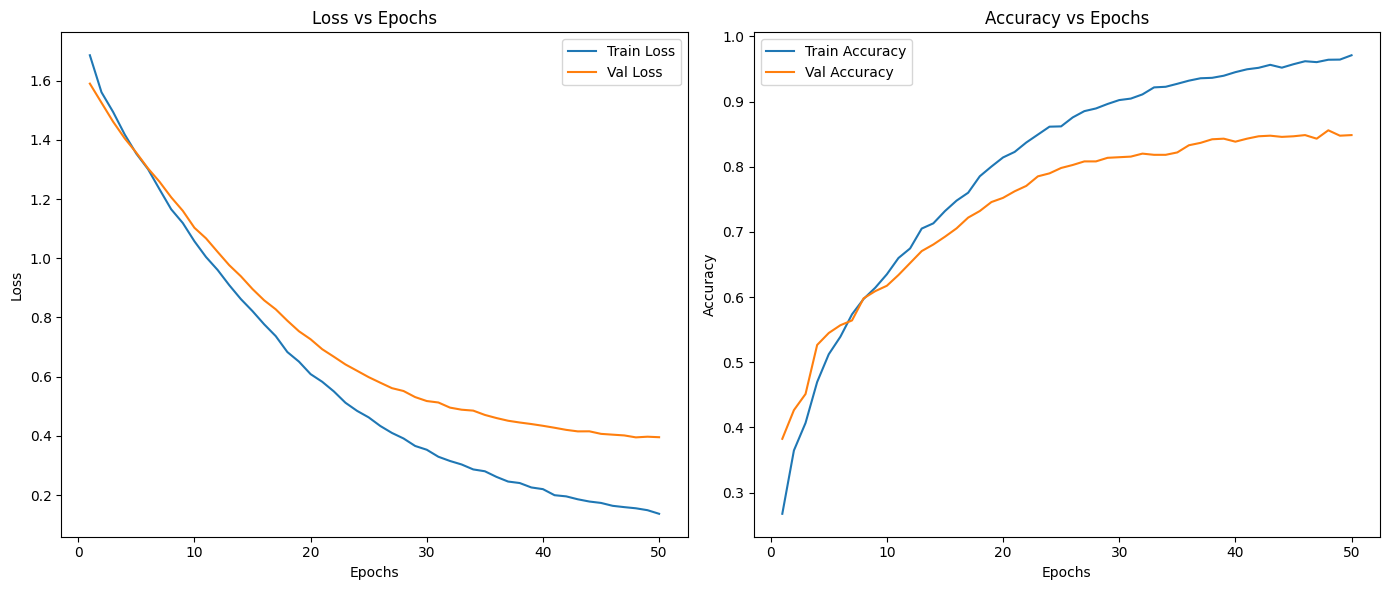

In [39]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))

# ---- Left: Loss vs Epochs ----
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, valid_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

# ---- Right: Accuracy vs Epochs ----
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, valid_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()
